# NSL Notebook 01



In [2]:
from default import *

## Exercise 01.1.1 01.1.2

In these exercises the main scope is to show how the **Blocking Method** permit to compute on the fly the statistical uncertainties realted to a Monte Carlo simulations.

My **blockingMethod** function create for every MC simulation a `.csv` with two columns, the first one is the mean value over the iterations (or **blocks**) and the second one is the related uncertainty.

Below the results for $\langle r \rangle$ and $\sigma^2_r$ using $10^5$ blocks.

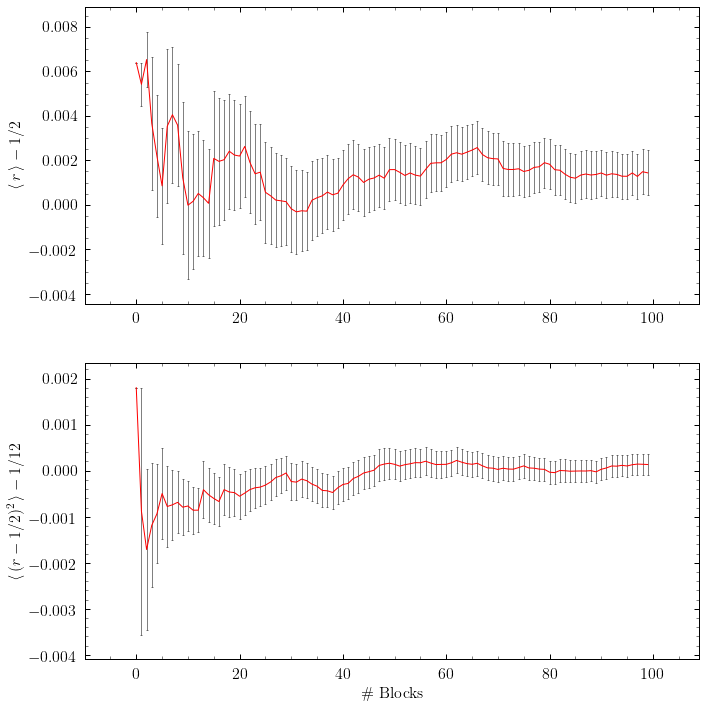

In [2]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(11,12))

# load mean conv
df_mean = pd.read_csv("mean01-blk.csv", header=None, names=["mean","mean_err"])
(df_mean["mean"]-0.5).plot.line(yerr=df_mean["mean_err"], 
                                color='r', 
                                ecolor='gray', 
                                capthick=0.5, 
                                ax=ax1)

# load variance conv
df_var = pd.read_csv("var01-blk.csv", header=None, names=["var","var_err"])
(df_var["var"]-1./12.).plot.line(yerr=df_var["var_err"], 
                                 color='r', 
                                 ecolor='gray', 
                                 capthick=0.5, 
                                 ax=ax2)

ax1.set_ylabel("$\langle\,r\,\\rangle-1/2$");

ax2.set_xlabel("\# Blocks");
ax2.set_ylabel("$\langle\,(r-1/2)^2\,\\rangle-1/12$");

## Exercise 01.1.3

Here we want to prove that random number generation is not uniform as we can expect, cause there is always a deterministic algorithm behind the scene. So it's not possible to obtain precise uniform distribution from random generation.

Using $\chi^2$ distribution like:

$$
\chi^2 = \sum_{i=i}^{M}\dfrac{(n_i - E_i)^2}{E_i}
$$

with $M=100$, if random generator is not uniform $E_i=10^4/M$ will almost be greater than real value $n_i$ inside i-th interval. So:

$$ (n_i - E_i)^2 \simeq E_i \Rightarrow \chi^2 \simeq 100 $$

To test this trend, $\chi^2$ was computed $100$ times and than plotted the difference $\chi^2/100 - 1$

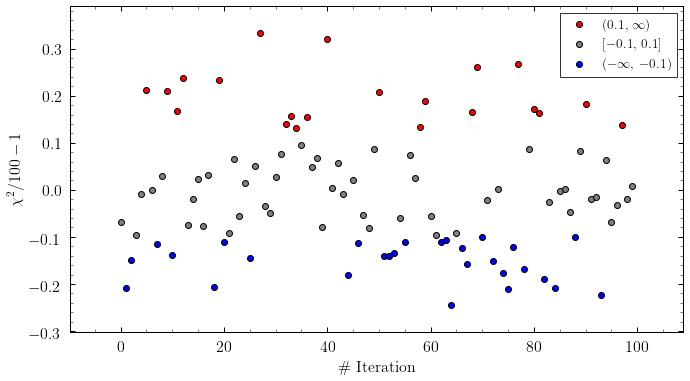

In [2]:
fig, ax = plt.subplots()

# chi^2/100 - 1
df = pd.read_csv("chi.out", header=None)/100.-1

hi = df.where(df>0.1)                           # (0.1,_)    range
mi = df.where(np.logical_and(df>-0.1,df<0.1))   # [-0.1,0.1] range
lo = df.where(df<-0.1)                          # (_,-0,1)   range

hi.plot.line(ls='', marker='o', markerfacecolor='r', ax=ax)
mi.plot.line(ls='', marker='o', markerfacecolor='gray', ax=ax)
lo.plot.line(ls='', marker='o', markerfacecolor='b', ax=ax)

ax.legend(["$(0.1,\,\infty)$", "$[-0.1,\,0.1]$", "$(-\infty,\,-0.1)$"], 
          fontsize="small");

ax.set_xlabel("\# Iteration");
ax.set_ylabel("$\chi^2/100 - 1$");

## Exercise 01.2

For this exercise the main scope is to check **Central Limit Theorem** for diffent random variables:

* Gaussian
* Exponential
* Lorentzian

the last one not meets the hypothesis of **CLT** cause $\sigma^2$ is not finite, so we can expect that Gaussian distribution for $N\rightarrow\infty$ won't be reached.

Plot dividing $N=[1,2,3]$ from $N=100$ for a clear fit.

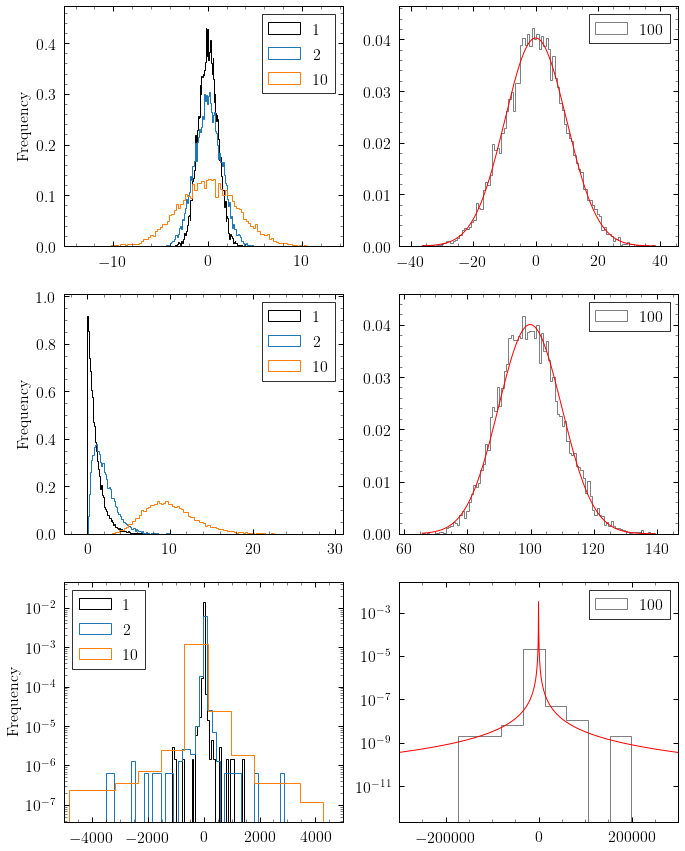

In [15]:
from scipy import stats

def fit_dist(S):
    """Gaussian fitting function return fitting series"""
    m, s = stats.norm.fit(S)
    x = np.linspace(S.min(), S.max(), S.size)
    y = stats.norm.pdf(x, m, s)
    return (x, y)

def fit_dist_c(S):
    """Cauchy fitting function return fitting series"""
    m, s = stats.cauchy.fit(S)
    x = np.linspace(S.min(), S.max(), S.size)
    y = stats.cauchy.pdf(x, m, s)
    return (x, y)
    
fig, ax_t = plt.subplots(3, 2, figsize=(11,15))

dists = ["Gauss", "Exp", "Cauchy"]  # type of distro
values = ["1", "2", "10", "100"]    # Sum values
df_dict = dict()                    # appo dict

for dist in dists:
    df_dict[dist] = pd.DataFrame(index=np.arange(10000))

# load data and fill dataframe dict
for dist in dists:
    for value in values:
        df_dict[dist][value] = pd.read_csv(dist + "-" + value + ".out", header=None)

# plot them
for dist, ax in zip(dists, ax_t):
    nbins = 100 #if dist == "Cauchy" else 100
    for value in values:
        if value != "100":
            df_dict[dist][value].plot.hist(density=True, 
                                           bins=nbins, 
                                           histtype='step', 
                                           label=value, ax=ax[0])
            ax[0].legend();
        else:
            df_dict[dist][value].plot.hist(density=True, 
                                           bins=nbins, 
                                           histtype='step', 
                                           color='gray', 
                                           ax=ax[1])
            
            # fit only Gauss and Exp distro for N = 100
            if dist != "Cauchy":
                x, y = fit_dist(df_dict[dist][value])
                ax[1].plot(x, y, 'r-')
            else:
                x, y = fit_dist_c(df_dict[dist][value])
                ax[1].plot(x, y, 'r-')
            
    ax[1].legend();
    ax[1].set_ylabel("");

    if dist == "Cauchy":
        ax[0].set_yscale('log');
        ax[1].set_yscale('log');
        ax[0].set_xlim([-5000, 5000]);
        ax[1].set_xlim([-300000, 300000]);
        #ax[1].ticklabel_format(axis='x', style='sci', scilimits=(0,0));
    else:
        None

## Exercise 01.3

Numerically test one of the first historical examples of MC simulation: **Buffon’s experiment**

The purpose is to compute $\pi$ throwing needles with lenght $L$ random onto a horizontal plane ruled with straight lines at distance $d$. The result is that:

$$ \pi = \dfrac{2\,L\,N_{th}}{N_{hit}\,d} $$

where $N_{th}$ are the number of throws, and $N_{hit}$ the number of intersections with lines.

My numeric simulation consist of:

1. Random position of needle center from $[0,\,L]$
2. Random angle onto the plane, so random cosine from $[-1,\,1]$ without using $\pi$, so not computed using $\cos(r_{[0,2\,\pi]})$ but using something like [this](https://math.stackexchange.com/questions/3183253/sine-cosine-of-random-angle-from-0-to-2-pi)
3. With needle center, needle lenght and cosine of angle, test if the needle touched the line or not, if yes `nhit++`, else do nothing
4. Repeat until $N_{th}$ is reached

These four points repeated $100$ times (or **blocks**) with $N_{th}=10^6$ to compute a blocking method of $\pi$ simulation, to show also the progression of errors.

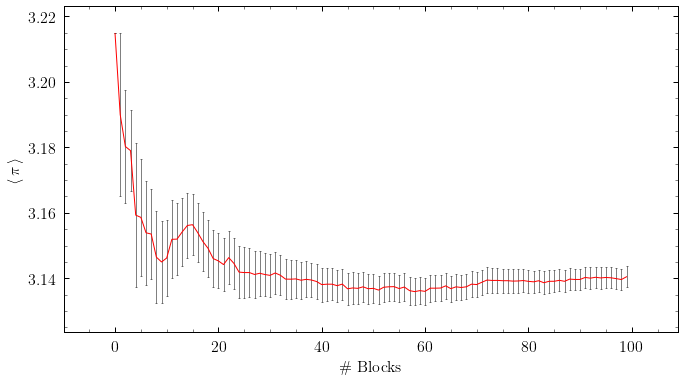

In [3]:
fig, ax = plt.subplots()

# load mean conv
df_mean = pd.read_csv("pi-blk.csv", header=None, names=["mean","mean_err"])
(df_mean["mean"]).plot.line(yerr=df_mean["mean_err"], 
                            color='r', 
                            ecolor='gray', 
                            capthick=0.5, 
                            ax=ax)

ax.set_xlabel("\# Blocks");
ax.set_ylabel("$\langle\,\pi\,\\rangle$");